In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

genotype_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_rare_variant/pro_assoc/02.snp_to_soma/low_missing_genotype.csv"
age_sex_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/Proteome/case_control_prepare/sample.csv"
pro_ex_df = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/Proteome/Soma_QC_re/Results/04.phom_day0_vs_naga/PHOMday0_vs_NAGA.ex.csv"

genotype_df = pd.read_csv(genotype_path, index_col=0)
age_sex_df = pd.read_csv(age_sex_path, index_col=0)
pro_ex = pd.read_csv(pro_ex_df, index_col=0)

In [2]:
age_sex_df = age_sex_df.drop('SampleCode', axis=1)
age_sex_df['sex_male1_female2'] = age_sex_df['sex_male1_female2'].replace(2, 0)
age_sex_df = age_sex_df.rename(columns={'sex_male1_female2': 'sex'})
age_sex_df.index = age_sex_df.index.str.replace('_day0', '')
age_sex_df = age_sex_df.loc[age_sex_df.index.intersection(genotype_df.columns)]

scaler = StandardScaler()
age_sex_df['age'] = scaler.fit_transform(age_sex_df[['age']])

In [3]:
selected_snp = ['chr5:96783162:C:T', 'chr6:31506394:C:T', 'chr7:12570952:C:T', 
                'chr11:126338337:G:C', 'chr15:73260253:T:TCCACTTTTCCTTC', 'chr15:81319380:A:G', 
                'chr16:56982238:G:A', 'chr17:66223742:CA:C', 'chr20:23444046:T:C']

genotype_df = genotype_df.loc[selected_snp]
genotype_df = genotype_df.replace({'0/0': 0, '1/0': 1, '0/1': 1, '1/1': 2}) # 0: ref, 1: het, 2: hom; there is no hom in this dataset
genotype_df = genotype_df.astype('float64')

genotype_df = genotype_df.transpose()
genotype_df = genotype_df.reindex(age_sex_df.index)

/tmp/ipykernel_2909119/1210237420.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  genotype_df = genotype_df.replace({'0/0': 0, '1/0': 1, '0/1': 1, '1/1': 2}) # 0: ref, 1: het, 2: hom; there is no hom in this dataset


In [4]:
pro_ex.index = pro_ex.index.str.replace('_day0', '')
pro_ex = pro_ex.loc[pro_ex.index.isin(genotype_df.index)]
pro_ex_log2 = np.log2(pro_ex)

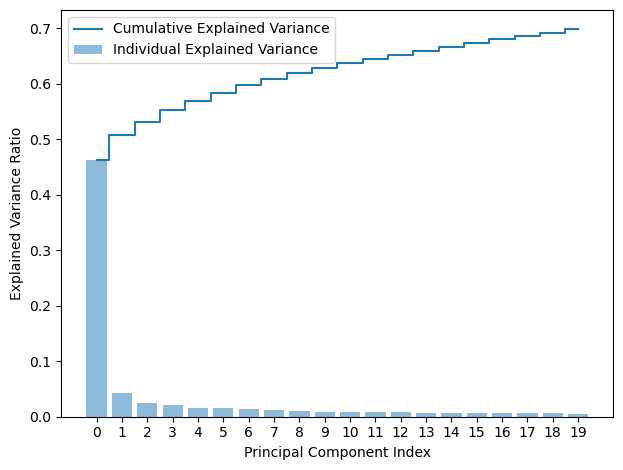

In [5]:
from sklearn.decomposition import PCA

def plot_pca_variance(pca, num_components):
    
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    plt.style.use('default')
    plt.bar(range(num_components), exp_var_pca[:num_components], alpha=0.5, align='center', label='Individual Explained Variance')
    plt.step(range(num_components), cum_sum_eigenvalues[:num_components], where='mid',label='Cumulative Explained Variance')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component Index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.style.use('default')
    plt.xticks(range(num_components), range(num_components))
    plt.show()

pca = PCA()
pca_pro_ex_log2 = pca.fit_transform(pro_ex_log2)
pca_pro_ex_log2 = pd.DataFrame(pca_pro_ex_log2)
pca_pro_ex_log2.index = pro_ex_log2.index

plot_pca_variance(pca=pca, num_components=20)

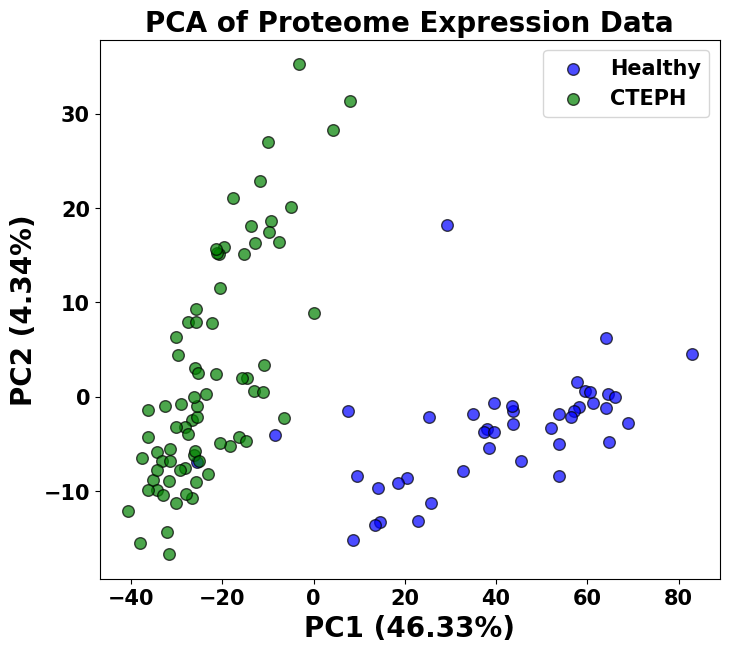

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')  # Set the style of the plot
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.weight'] = 'bold'

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 7))
unique_labels = list(set([idx[0] for idx in pca_pro_ex_log2.index]))
color_map = {'N': 'green', 'P': 'blue'}  # Assuming 'H' for Healthy and 'C' for CTEPH

for label in unique_labels:
    idx = [i for i, idx in enumerate(pca_pro_ex_log2.index) if idx.startswith(label)]
    plt.scatter(pca_pro_ex_log2.iloc[idx, 0], pca_pro_ex_log2.iloc[idx, 1], label=label, color=color_map[label], alpha=0.7, s=70, edgecolors='black')

plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}%)', fontsize=20, weight='bold')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}%)', fontsize=20, weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Healthy', 'CTEPH'], loc='best', fontsize=15)
plt.title('PCA of Proteome Expression Data', fontsize=20, weight='bold')
plt.show()

In [7]:
pc1_pro_ex_log2 = pca_pro_ex_log2.iloc[:, 0]
pc1_pro_ex_log2.name = 'PC1'

In [18]:
import statsmodels.api as sm
import pandas as pd

results_dict = {}
all_data = age_sex_df.join([pc1_pro_ex_log2.to_frame('PC1'), genotype_df])

for snp_id in genotype_df.columns:
    
    safe_snp_id = 'Q("' + snp_id + '")' # using safe SNP ID for formula construction
    formula = 'PC1 ~ age + sex + ' + safe_snp_id
    model = sm.OLS.from_formula(formula, data=all_data)

    result = model.fit()
    
    results_dict[snp_id] = pd.DataFrame({
        'age_beta': [result.params['age']],
        'age_pvalue': [result.pvalues['age']],
        'age_sd': [result.bse['age']],
        'sex_beta': [result.params['sex']],
        'sex_pvalue': [result.pvalues['sex']],
        'sex_sd': [result.bse['sex']],
        'genotype_beta': [result.params[safe_snp_id]],
        'genotype_pvalue': [result.pvalues[safe_snp_id]],
        'genotype_sd': [result.bse[safe_snp_id]]
    })


In [32]:
result_df = pd.DataFrame(columns=['age_beta', 'age_pvalue', 'age_sd', 
                                  'sex_beta', 'sex_pvalue', 'sex_sd', 
                                  'genotype_beta', 'genotype_pvalue', 'genotype_sd'])

for snp_id, data in results_dict.items():
    data.index = [snp_id]
    result_df = pd.concat([result_df, data])


/tmp/ipykernel_2909119/3670179044.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, data])


In [33]:
result_df

,age_beta,age_pvalue,age_sd,sex_beta,sex_pvalue,sex_sd,genotype_beta,genotype_pvalue,genotype_sd
chr5:96783162:C:T,-9.289168,0.000924,2.725996,-34.609690,2.659027e-08,5.762789,-3.274811,0.700888,8.502592
chr6:31506394:C:T,-9.844436,0.000473,2.726337,-37.379822,1.187766e-09,5.587597,0.076164,0.996433,16.994470
chr7:12570952:C:T,-8.935450,0.001780,2.782861,-37.597142,6.501190e-10,5.499268,8.583747,0.286165,8.004973
chr11:126338337:G:C,-9.002997,0.000666,2.569200,-33.812329,2.906447e-09,5.227999,0.418065,0.965574,9.664179
chr15:73260253:T:TCCACTTTTCCTTC,-7.700799,0.005048,2.691194,-36.170487,2.736792e-10,5.205397,7.284974,0.510501,11.034369
chr15:81319380:A:G,-8.926014,0.001269,2.696769,-36.086623,1.444027e-09,5.452077,5.404633,0.655908,12.096065
chr16:56982238:G:A,-8.082788,0.002951,2.656569,-37.933147,1.305447e-10,5.328487,18.208346,0.369690,20.212349
chr17:66223742:CA:C,-9.473844,0.000406,2.596613,-34.163341,4.444576e-09,5.356083,30.568452,0.021215,13.074914
chr20:23444046:T:C,-9.487827,0.000534,2.654235,-34.220100,8.167793e-09,5.453537,1.309143,0.919946,12.994559
